### Test different thresholds of IPC levels for FewsNet and Global IPC
For the anticipatory action framework, we want to define the trigger mechanism based on data. One of the possible data sources are IPC levels. Based on the historical analysis of FewsNet and Global IPC, and conversations with partners, different triggers were tested. This notebook provides a subset of tested triggers and the code to easily test any triggers of interest.   

The notebook was mad with Ethiopia data but can relatively easy be transferred to other countries   

IPC trigger design as of 08-10-2020:   
EITHER: At least 20% population of one or more ADMIN1 regions projected at IPC4+ in 3 months   
OR:    
At least 30% of ADMIN1 population projected at IPC3+ AND increase by 5 percentage points in ADMIN1 pop.  projected in IPC3+ in 3 months compared to current state

Main experimenting was done with FewsNet due to more historical data. The most rlevant triggers were also analysed for Global IPC

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import geopandas as gpd
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')

The updates of 2020-09-01 and 2020-08-01 don't include any CS data! For the analysis CS data of 2020-06 was used for those dates.

In [3]:
country="malawi"
start_date_fews="20090701"
end_date_fews="20201001"

In [4]:
df_fadm=pd.read_csv(f"Data/FewsNetCombined/{country}_admin1_fewsnet_combined_{start_date_fews}_{end_date_fews}.csv",index_col=0)
df_fadm['date'] = pd.to_datetime(df_fadm['date'])
df_fadm['year'] = df_fadm['date'].dt.year
df_fadm['month'] = df_fadm['date'].dt.month
adm1c='ADM1_EN' #"ADMIN1" #

In [5]:
def add_columns(df):
    #Population not food-insecure
    df["CS_12"]=df["CS_1"]+df["CS_2"]
    #calculate percentage of population per status and level
    for status in ["CS","ML1","ML2"]:
        for i in range(1,6):
            c=f"{status}_{i}"
            df[f"perc_{c}"]=df[c]/df[f"pop_{status}"]*100
        df[f"{status}_3p"]=df[f"{status}_3"]+df[f"{status}_4"]+df[f"{status}_5"]
        df[f"perc_{status}_3p"]=df[f"{status}_3p"]/df[f"pop_{status}"]*100
        df[f'{status}_2-']=df[[f'{status}_{i}' for i in range(1,3)]].sum(axis=1)
        df[f'perc_{status}_2-']=df[f'{status}_2-']/df[f'pop_{status}']*100
    return df

In [6]:
df_fadm=add_columns(df_fadm)

In [7]:
#never been or forecasted to be IPC 5
print("CS 5",df_fadm.CS_5.unique())
print("ML1 5", df_fadm.ML1_5.unique())

CS 5 [ 0. nan]
ML1 5 [0.]


In [8]:
df_fadm.head()

,date,ADM1_EN,Total,adjusted_population,CS_1,CS_2,CS_3,CS_4,CS_5,ML1_1,...,perc_ML1_2-,perc_ML2_1,perc_ML2_2,perc_ML2_3,perc_ML2_4,perc_ML2_5,ML2_3p,perc_ML2_3p,ML2_2-,perc_ML2_2-
0,2009-07-01,Central,6512416.0,6239643.0,6239643.0,0.0,0.0,0.0,0.0,6239643.0,...,100.0,100.00000,0.00000,0.0,0.0,0.0,0.0,0.0,6239643.0,100.0
1,2009-07-01,Northern,1459888.0,1398738.0,1388671.0,0.0,0.0,0.0,0.0,1388671.0,...,100.0,100.00000,0.00000,0.0,0.0,0.0,0.0,0.0,1388671.0,100.0
2,2009-07-01,Southern,6773465.0,6489757.0,5615307.0,874450.0,0.0,0.0,0.0,5615307.0,...,100.0,86.52569,13.47431,0.0,0.0,0.0,0.0,0.0,6489757.0,100.0
3,2009-10-01,Central,6512416.0,6239643.0,6239643.0,0.0,0.0,0.0,0.0,6239643.0,...,100.0,100.00000,0.00000,0.0,0.0,0.0,0.0,0.0,6239643.0,100.0
4,2009-10-01,Northern,1459888.0,1398738.0,1388671.0,0.0,0.0,0.0,0.0,1388671.0,...,100.0,100.00000,0.00000,0.0,0.0,0.0,0.0,0.0,1388671.0,100.0


In [9]:
def get_trigger(row, status, level, perc):
    """
    Return 1 if percentage of population in row for status in level "level" or higher, equals or larger than perc
    """
    # range till 6 cause 5 is max level
    cols = [f"{status}_{l}" for l in range(level, 6)]
    if np.isnan(row[f"pop_{status}"]):
        return np.nan
    if round(row[cols].sum()/row[f"pop_{status}"]*100) >= perc:
        return 1
    else:
        return 0


def get_trigger_increase_rel(row, level, perc):
    """
    Return 1 if population in row for >="level" at ML1 is expected to be larger than (current (CS) population in >=level) * (1+(perc/100))
    """
    # range till 6 cause 5 is max level
    cols_ml1 = [f"ML1_{l}" for l in range(level, 6)]
    cols_cs = [f"CS_{l}" for l in range(level, 6)]
    if row[["pop_CS", "pop_ML1"]].isnull().values.any():
        return np.nan
    if row[cols_ml1].sum() == 0:
        return 0
    if row[cols_ml1].sum() >= row[cols_cs].sum() * (1 + (perc / 100)):
        return 1
    else:
        return 0
    
def get_trigger_increase(row, status, level, perc):
    """
    Return 1 if for row percentage in >="level" at status minus percentage in >="level" currently (CS) is expected to be larger than perc
    For Global IPC the population analysed in ML2 is sometimes different than in CS. That is why we work dirrectly with percentages and not anymore with (pop status level+ - pop CS level+) / pop CS
    """
    # range till 6 cause 5 is max level
    cols_perc_ml = [f"perc_{status}_{l}" for l in range(level, 6)]
    cols_perc_cs = [f"perc_CS_{l}" for l in range(level, 6)]
    if row[["pop_CS", f"pop_{status}"]].isnull().values.any():
        return np.nan
    if row[cols_perc_ml].sum() == 0:
        return 0
    if round(row[cols_perc_ml].sum() - row[cols_perc_cs].sum()) >= perc:
        return 1
    else:
        return 0

In [10]:
#get yes/no for different thresholds, i.e. column value for row will be 1 if threshold is met and 0 if it isnt
df_fadm["trigger_CS_3_20"]=df_fadm.apply(lambda x: get_trigger(x,"CS",3,20),axis=1)
df_fadm["trigger_CS_3_30"]=df_fadm.apply(lambda x: get_trigger(x,"CS",3,30),axis=1)
df_fadm["trigger_CS_3_40"]=df_fadm.apply(lambda x: get_trigger(x,"CS",3,40),axis=1)
df_fadm["trigger_CS_4_2"]=df_fadm.apply(lambda x: get_trigger(x,"CS",4,2.5),axis=1)
df_fadm["trigger_CS_4_20"]=df_fadm.apply(lambda x: get_trigger(x,"CS",4,20),axis=1)
df_fadm["trigger_CS_4_10"]=df_fadm.apply(lambda x: get_trigger(x,"CS",4,10),axis=1)
df_fadm["trigger_CS_4_1"]=df_fadm.apply(lambda x: get_trigger(x,"CS",4,0.1),axis=1)
df_fadm["trigger_ML1_3_5"]=df_fadm.apply(lambda x: get_trigger(x,"ML1",3,5),axis=1)
df_fadm["trigger_ML1_4_2"]=df_fadm.apply(lambda x: get_trigger(x,"ML1",4,2.5),axis=1)
df_fadm["trigger_ML1_4_20"]=df_fadm.apply(lambda x: get_trigger(x,"ML1",4,20),axis=1)
df_fadm["trigger_ML1_3_20"]=df_fadm.apply(lambda x: get_trigger(x,"ML1",3,20),axis=1)
df_fadm["trigger_ML1_3_30"]=df_fadm.apply(lambda x: get_trigger(x,"ML1",3,30),axis=1)
df_fadm["trigger_ML1_3_5ir"]=df_fadm.apply(lambda x: get_trigger_increase_rel(x,3,5),axis=1)
df_fadm["trigger_ML1_3_40ir"]=df_fadm.apply(lambda x: get_trigger_increase_rel(x,3,40),axis=1)
df_fadm["trigger_ML1_3_70ir"]=df_fadm.apply(lambda x: get_trigger_increase_rel(x,3,70),axis=1)
df_fadm["trigger_ML1_3_5i"]=df_fadm.apply(lambda x: get_trigger_increase(x,"ML1",3,5),axis=1)
df_fadm["trigger_ML1_3_10i"]=df_fadm.apply(lambda x: get_trigger_increase(x,"ML1",3,10),axis=1)
df_fadm["trigger_ML1_3_20i"]=df_fadm.apply(lambda x: get_trigger_increase(x,"ML1",3,20),axis=1)
df_fadm["trigger_ML1_3_30i"]=df_fadm.apply(lambda x: get_trigger_increase(x,"ML1",3,30),axis=1)
df_fadm["trigger_ML1_3_40i"]=df_fadm.apply(lambda x: get_trigger_increase(x,"ML1",3,40),axis=1)
df_fadm["trigger_ML1_3_50i"]=df_fadm.apply(lambda x: get_trigger_increase(x,"ML1",3,50),axis=1)
df_fadm["trigger_ML1_3_70i"]=df_fadm.apply(lambda x: get_trigger_increase(x,"ML1",3,70),axis=1)
df_fadm["trigger_ML2_4_20"]=df_fadm.apply(lambda x: get_trigger(x,"ML2",4,20),axis=1)
df_fadm["trigger_ML2_3_30"]=df_fadm.apply(lambda x: get_trigger(x,"ML2",3,30),axis=1)
df_fadm["trigger_ML2_3_5i"]=df_fadm.apply(lambda x: get_trigger_increase(x,"ML2",3,5),axis=1)

In [11]:
#initialize dict with all the analyses
dict_fan={}

In [12]:
#currently (Oct 2020) selected trigger
df_an1=df_fadm.loc[(df_fadm["trigger_ML1_4_20"]==1) | ((df_fadm["trigger_ML1_3_30"]==1) & (df_fadm["trigger_ML1_3_5i"]==1))]
display(df_an1.groupby(['year', 'month'], as_index=False)['ADM1_EN','perc_ML1_4','perc_CS_3p','perc_ML1_3p'].agg(lambda x: list(x)))
dict_fan["an1"]={"df":df_an1,"trig_cols":["ML1_3p","CS_3p","ML1_4"],"desc":"At least 20% of ADMIN1 population in IPC4+ at ML1 OR (At least 30% of ADMIN1 population projected at IPC3+  AND increase by 5 percentage points in ADMIN1 pop.  projected in IPC3+ compared to current state)"}

,year,month,ADM1_EN,perc_ML1_4,perc_CS_3p,perc_ML1_3p
0,2014,7,[Southern],[0.0],[0.0],[36.9574572440826]
1,2016,6,[Southern],[0.0],[22.81882438565054],[84.69930932106561]
2,2016,10,"[Central, Southern]","[0.0, 0.0]","[71.35133214452567, 39.02328387428039]","[88.37576411599429, 100.0]"


In [13]:
#Analysis 2: At least 20% of ADMIN1 population at IPC4+ in ML1
df_an2 = df_fadm.loc[(df_fadm["trigger_ML1_4_20"]==1)]
display(df_an2.groupby(['year', 'month'], as_index=False)['ADM1_EN','perc_ML1_4'].agg(lambda x: list(x)))
dict_fan["an2"]={"df":df_an2,"trig_cols":["ML1_3","CS_3","CS_4","ML1_4"],"desc":"At least 20% of ADMIN1 population in IPC4+ at ML1"}

""


In [14]:
#Analysis 3: At least 30% of ADMIN1 population projected to be at IPC3+  AND5% increase in ADMIN1 pop. projected in IPC3+ in 3 months
df_an3 = df_fadm.loc[(df_fadm["trigger_ML1_3_30"]==1) & (df_fadm["trigger_ML1_3_5i"]==1)]
display(df_an3.groupby(['year', 'month'], as_index=False)['ADM1_EN','perc_CS_3p','perc_ML1_3p'].agg(lambda x: list(x)))
dict_fan["an3"]={"df":df_an3,"trig_cols":["ML1_3","CS_3","CS_4","ML1_4"],"desc":"At least 30% of ADMIN1 population in ML1 at IPC3+  AND5% increase in ADMIN1 pop. projected in IPC3+ in 3 months"}

,year,month,ADM1_EN,perc_CS_3p,perc_ML1_3p
0,2014,7,[Southern],[0.0],[36.9574572440826]
1,2016,6,[Southern],[22.81882438565054],[84.69930932106561]
2,2016,10,"[Central, Southern]","[71.35133214452567, 39.02328387428039]","[88.37576411599429, 100.0]"


In [15]:
# #Some previously tested triggers
# #More triggers were analysed, the ones below substitute a subset which shows the variety of investigated triggers
# #Analysis 4: 20% IPC3+ (current situation) + 2.5% IPC4+ (current situation)
# df_an4 = df_fadm.loc[(df_fadm['trigger_CS_3_20']==1)&(df_fadm['trigger_ML1_4_2']==1)]
# dict_fan["an4"]={"df":df_an4,"trig_cols":["CS_3","CS_4","ML1_4"],"desc":"20% IPC3+ (current situation) + 2.5% IPC4+ (current situation)"}

# #Analysis 5: 20% IPC3+ (current situation) + (2.5% IPC4+ (current situation) OR 5% RELATIVE increase in IPC3+ (ML1))
# df_an5 = df_fadm.loc[(df_fadm['trigger_CS_3_20']==1)&((df_fadm['trigger_ML1_4_2']==1)| (df_fadm['trigger_ML1_3_5ir'] == 1))]
# dict_fan["an5"]={"df":df_an5,"trig_cols":["CS_3","CS_4","ML1_4"],"desc":"20% IPC3+ (current situation) + (2.5% IPC4+ (current situation) OR 5% RELATIVE increase in IPC3+ (ML1))"}

# #Analysis 6: 20% IPC3+ (current situation) + 2.5% IPC4+ (current situation) + 5% RELATIVE increase in IPC3+ (ML1)
# df_an6 = df_fadm.loc[(df_fadm['trigger_CS_3_20']==1)&(df_fadm['trigger_CS_4_2']==1) & (df_fadm['trigger_ML1_3_5ir'] == 1)]
# dict_fan["an6"]={"df":df_an6,"trig_cols":["CS_3","CS_4","ML1_4"],"desc":"20% IPC3+ (current situation) + 2.5% IPC4+ (current situation) + 5% RELATIVE increase in IPC3+ (ML1)"}

# #Analysis 7: IPC4 at 20% (current situation)
# df_an7 = df_fadm.loc[df_fadm['trigger_CS_4_20']==1]
# dict_fan["an7"]={"df":df_an7,"trig_cols":["CS_4"],"desc":"IPC4 at 20% (current situation)"}

# #Analysis 8: 5% increase in IPC3+ (ML1)
# df_an8 = df_fadm.loc[(df_fadm['trigger_ML1_3_5i']==1)]
# dict_fan["an8"]={"df":df_an8,"trig_cols":["ML1_3","CS_3","CS_4","ML1_4"],"desc":"5% increase in number of people in IPC3+ (ML1)"}

# #Analysis 9: At least 20% of ADMIN1 population projected to be at IPC3+  AND5% increase in ADMIN1 pop. projected in IPC3+ in 3 months
# df_an9 = df_fadm.loc[(df_fadm["trigger_ML1_3_20"]==1) & (df_fadm["trigger_ML1_3_5i"]==1)]
# dict_fan["an9"]={"df":df_an9,"trig_cols":["ML1_3","CS_3","CS_4","ML1_4"],"desc":"At least 20% of ADMIN1 population in ML1 at IPC3+  AND5% increase in ADMIN1 pop. projected in IPC3+ in 3 months"}

# #Analysis 10: At least 20% of population projected in ML2 in IPC4+
# df_an10=df_fadm.loc[(df_fadm['trigger_ML2_4_20']==1)]
# dict_fan["an10"]={"df":df_an10,"trig_cols":["ML2_4"],"desc":"20% of population projected in ML2 in IPC4+"}

# #Analysis 11: At least 20% of population projected in ML2 in IPC4+ OR (30% in ML2 in IPC3+ AND 5% increase in IPC3+ in ML2 compared to CS)
# df_an11=df_fadm.loc[(df_fadm["trigger_ML2_4_20"]) | ((df_fadm["trigger_ML2_3_30"]==1)&(df_fadm["trigger_ML2_3_5i"]==1))]
# display(df_an11.groupby(['year', 'month'], as_index=False)['ADM1_EN','perc_CS_3p','perc_ML2_3p','perc_ML2_4'].agg(lambda x: list(x)))
# dict_fan["an11"]={"df":df_an11,"trig_cols":["ML2_3","ML2_4"],"desc":"20% in ML2 in IPC4 OR (30% in ML2 in IPC3+ AND 5% increase in IPC3+ in ML2 compared to CS)"}

In [16]:
df_fadm[df_fadm.trigger_CS_3_30==1]

,date,ADM1_EN,Total,adjusted_population,CS_1,CS_2,CS_3,CS_4,CS_5,ML1_1,...,trigger_ML1_3_5i,trigger_ML1_3_10i,trigger_ML1_3_20i,trigger_ML1_3_30i,trigger_ML1_3_40i,trigger_ML1_3_50i,trigger_ML1_3_70i,trigger_ML2_4_20,trigger_ML2_3_30,trigger_ML2_3_5i
62,2014-10-01,Southern,6773465.0,7482590.0,4717215.0,0.0,2765375.0,0.0,0.0,4717215.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0
74,2015-10-01,Southern,6773465.0,7691944.0,507116.0,2522157.0,4662671.0,0.0,0.0,507116.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,1.0
81,2016-10-01,Central,6512416.0,7598650.0,502313.0,1674599.0,5421738.0,0.0,0.0,502313.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0,1,1.0
83,2016-10-01,Southern,6773465.0,7903238.0,0.0,4819135.0,3084103.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1,1,1.0
101,2018-12-01,Southern,6773465.0,8334121.0,136009.0,851337.0,7346775.0,0.0,0.0,136009.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0
110,2019-10-01,Southern,6773465.0,8557103.0,3911840.0,0.0,4645263.0,0.0,0.0,3911840.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0.0


In [17]:
#Analysis 12: At least 20% of population in IPC3+ in CS
df_an12=df_fadm.loc[df_fadm["trigger_CS_3_20"]==1]
display(df_an12.groupby(['year', 'month'], as_index=False)['ADM1_EN','perc_CS_3p'].agg(lambda x: list(x)))
dict_fan["an12"]={"df":df_an12,"trig_cols":["CS_3","CS_4","CS_5"],"desc":"20% of population in IPC3+ in CS"}

#Analysis 13: At least 30% of population in IPC3+ in CS
df_an13=df_fadm.loc[df_fadm["trigger_CS_3_30"]==1]
display(df_an13.groupby(['year', 'month'], as_index=False)['ADM1_EN','perc_CS_3p'].agg(lambda x: list(x)))
dict_fan["an13"]={"df":df_an13,"trig_cols":["CS_3","CS_4","CS_5"],"desc":"30% of population in IPC3+ in CS"}

,year,month,ADM1_EN,perc_CS_3p
0,2014,10,[Southern],[36.9574572440826]
1,2015,1,[Southern],[19.601273748222816]
2,2015,10,[Southern],[60.6175889996079]
3,2016,6,[Southern],[22.81882438565054]
4,2016,10,"[Central, Southern]","[71.35133214452567, 39.02328387428039]"
5,2018,12,[Southern],[88.15296778148529]
6,2019,10,"[Northern, Southern]","[26.165920680577887, 54.285463199402884]"


,year,month,ADM1_EN,perc_CS_3p
0,2014,10,[Southern],[36.9574572440826]
1,2015,10,[Southern],[60.6175889996079]
2,2016,10,"[Central, Southern]","[71.35133214452567, 39.02328387428039]"
3,2018,12,[Southern],[88.15296778148529]
4,2019,10,[Southern],[54.285463199402884]


In [18]:

def col_pop(row,col,df):
    pop_col=df[df.date==row.date][col].sum()
    return pop_col

def col_perc(row,col,df):
    s=col.split("_")[0]
    return df[df.date==row.date][col].sum()/df[df.date==row.date][f"pop_{s}"].sum()*100

In [19]:
#plot all analysis in nicer format
for k in dict_fan.keys():
    d=dict_fan[k]["desc"]
    num_k=k.replace("an","")
    print(f"Analysis {num_k}: FewsNet, {d}")
    df=dict_fan[k]["df"]
    df_grouped=df.groupby(['year', 'month'], as_index=False)['ADM1_EN'].agg(lambda x: list(x))
    if df_grouped.empty:
        display(df_grouped)
    else:
        df_grouped["ADM1_EN"]=[', '.join(map(str, l)) for l in df_grouped["ADM1_EN"]]
        df_grouped["Trigger description"]=d
        df_grouped=df_grouped.rename(columns={"ADM1_EN":"Regions triggered","pop_reg":"pop. threshold regions"})
        df_grouped_clean=df_grouped[["year","month","Regions triggered"]].set_index(['year', 'month'])
        display(df_grouped[["year","month","Regions triggered"]].set_index(['year', 'month']))
        b=df_grouped[["year","month","Regions triggered","Trigger description"]].set_index(['Trigger description','year', 'month'])

Analysis 1: FewsNet, At least 20% of ADMIN1 population in IPC4+ at ML1 OR (At least 30% of ADMIN1 population projected at IPC3+  AND increase by 5 percentage points in ADMIN1 pop.  projected in IPC3+ compared to current state)


Regions triggered
year month                   
2014 7               Southern
2016 6               Southern
     10     Central, Southern

Analysis 2: FewsNet, At least 20% of ADMIN1 population in IPC4+ at ML1


""


Analysis 3: FewsNet, At least 30% of ADMIN1 population in ML1 at IPC3+  AND5% increase in ADMIN1 pop. projected in IPC3+ in 3 months


Regions triggered
year month                   
2014 7               Southern
2016 6               Southern
     10     Central, Southern

Analysis 12: FewsNet, 20% of population in IPC3+ in CS


Regions triggered
year month                    
2014 10               Southern
2015 1                Southern
     10               Southern
2016 6                Southern
     10      Central, Southern
2018 12               Southern
2019 10     Northern, Southern

Analysis 13: FewsNet, 30% of population in IPC3+ in CS


,,Regions triggered
year,month,
2014,10,Southern
2015,10,Southern
2016,10,"Central, Southern"
2018,12,Southern
2019,10,Southern


### FewsNet, percentage population per phase

In [85]:
perc_cols=[col for col in df_fadm.columns if 'perc' in col]
df_foct20perc=df_fadm.loc[df_fadm.date=="2020-10",['date','ADM1_EN']+perc_cols]
perc_ML1_cols=[col for col in perc_cols if 'ML1' in col]
display(df_foct20perc[['date','ADM1_EN']+perc_ML1_cols])
df_foct20perc.to_csv("Experiments/Data/MWI_FewsNet_perc_phase_202010.csv",index=False)

,date,ADM1_EN,perc_ML1_1,perc_ML1_2,perc_ML1_3,perc_ML1_4,perc_ML1_5,perc_ML1_3p,perc_ML1_2-
120,2020-10-01,Central,92.751303,7.248697,0.000000,0.0,0.0,0.000000,100.000000
121,2020-10-01,Northern,100.000000,0.000000,0.000000,0.0,0.0,0.000000,100.000000
122,2020-10-01,Southern,61.928938,8.876556,29.194507,0.0,0.0,29.194507,70.805493


### FewsNet, plotting characteristics of the trigger

In [30]:
shape_path="Data/mwi_adm_nso_20181016_shp/mwi_admbnda_adm1_nso_20181016.shp" #"Data/ET_Admin1_OCHA_2019/eth_admbnda_adm1_csa_bofed_20190827.shp"

In [31]:
def plot_regions_trig(df_trig,adm0c="ADM0_EN",adm1c="ADM1_EN",shape_path="Data/ET_Admin1_OCHA_2019/eth_admbnda_adm1_csa_bofed_20190827.shp"):
     #'ET_Admin2_2014/ET_Admin2_2014.shp'
    gdf = gpd.read_file(shape_path)

    count = 1
    f, ax = plt.subplots(figsize=(12,12))
    for d in range(2009,2021):
        ax2 = plt.subplot(4, 4, count)
        gdf.plot(ax=ax2, color='#DDDDDD', edgecolor='#BBBBBB')
        regions = df_trig[adm1c].loc[df_trig['year']==d]
        if len(regions) > 0:
            gdf.loc[gdf[adm1c].isin(regions)].plot(ax=ax2, color='red')
        plt.title(f"Regions triggered {d}")
        count+=1
        ax2.axis("off")
    plt.show()

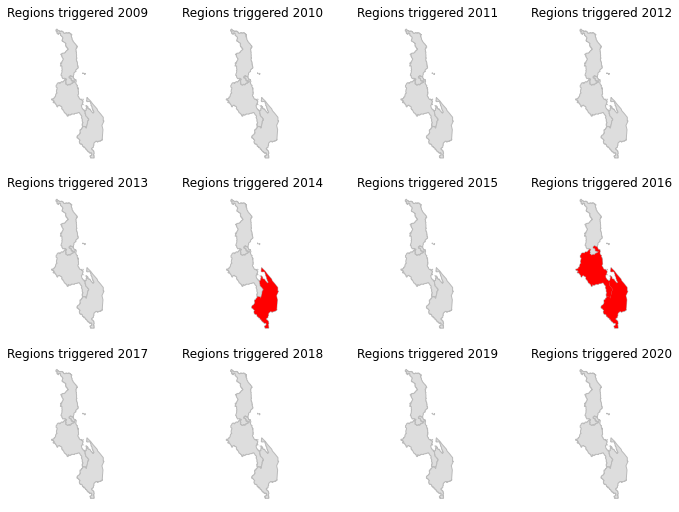

In [32]:
plot_regions_trig(dict_fan["an1"]["df"],shape_path=shape_path)

In [33]:
def plot_aff_dates(df_d,df_trig,col,shape_path="Data/ET_Admin1_OCHA_2019/eth_admbnda_adm1_csa_bofed_20190827.shp",title=None):
    
    num_dates=len(df_trig.date.unique())
    colp_num=2
    rows=num_dates // colp_num
    rows+=num_dates % colp_num
    position = range(1, num_dates + 1)

    gdf = gpd.read_file(shape_path)
    df_geo=gdf[["ADM1_EN","geometry"]].merge(df_d,on="ADM1_EN",how="left")
    
    colors = len(df_geo[col].unique())
    cmap = 'Blues'
    figsize = (16, 10)
    scheme = "natural_breaks"#'equalinterval'
    fig = plt.figure(1,figsize=(16,6*rows))
    
    for i,c in enumerate(df_trig.date.unique()):
        ax = fig.add_subplot(rows,colp_num,position[i])
        df_date=df_geo[df_geo.date==c]
        if df_date[col].isnull().values.all():
            print(f"No not-NaN values for {c}")
        elif df_date[col].isnull().values.any():
            df_geo[df_geo.date==c].plot(col, ax=ax,cmap=cmap, figsize=figsize, k = colors,  legend=True,scheme=scheme,missing_kwds={"color": "lightgrey", "edgecolor": "red",
   "hatch": "///",
    "label": "Missing values"})
        else:
            df_geo[df_geo.date==c].plot(col, ax=ax,cmap=cmap, figsize=figsize, k = colors,  legend=True,scheme=scheme)
        gdf.boundary.plot(linewidth=0.2,ax=ax)

        ax.axis("off")
        
        plt.title(pd.DatetimeIndex([c])[0].to_period('M'))
        if not df_date[col].isnull().values.all():
            leg = ax.get_legend()

            for lbl in leg.get_texts():
                label_text = lbl.get_text()
                upper = label_text.split(",")[-1].rstrip(']')

                try:
                    new_text = f'{float(upper):,.2f}'
                except:
                    new_text=upper
                lbl.set_text(new_text)

    if title:
        fig.suptitle(title,fontsize=14, y=0.92)
    plt.show()

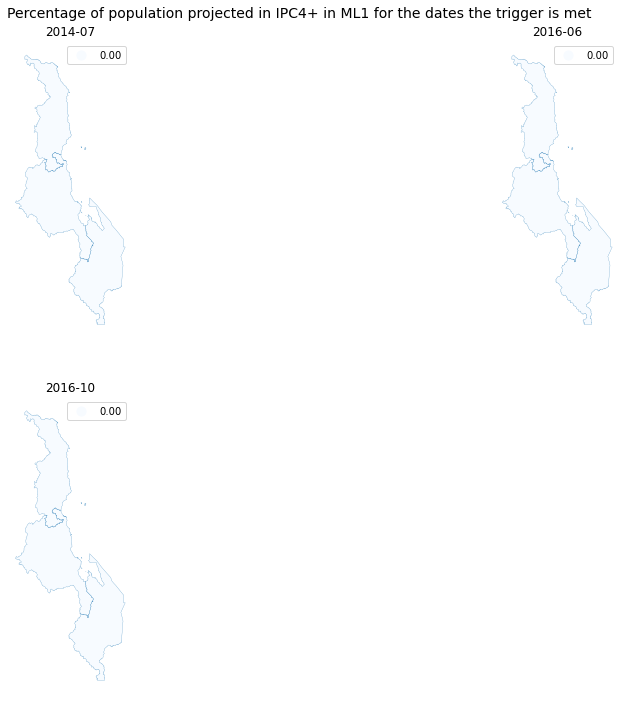

In [34]:
plot_aff_dates(df_fadm,dict_fan["an1"]["df"],"perc_ML1_4",title="Percentage of population projected in IPC4+ in ML1 for the dates the trigger is met",shape_path=shape_path)

#### Trigger analysis Global IPC data
One of the goals was to compare the two sources of IPC data. Below are the results on the Global IPC data with the final chosen trigger

In [35]:
df_ipcg=pd.read_excel("Data/GlobalIPC/GlobalIPC_newcolumnnames.xlsx",header=11)
df_ipcg=df_ipcg[df_ipcg.date.notnull()]
df_ipcg["date"]=pd.to_datetime(df_ipcg["date"])
df_ipcg['year'] = df_ipcg['date'].dt.year
df_ipcg['month'] = df_ipcg['date'].dt.month
#Due to excel setting, the percentages are loaded as fractions so convert to percentages
perc_cols=[col for col in df_ipcg.columns if 'perc' in col]
df_ipcg[perc_cols]=df_ipcg[perc_cols]*100

In [36]:
df_ipcg.head(n=3)

,Country,ADMIN1,ADMIN2,Analysis Name,date,pop_Country,pop_CS,perc_pop_CS,CS,CS_AP,...,ML2_3,perc_ML2_3,ML2_4,perc_ML2_4,ML2_5,perc_ML2_5,ML2_3p,perc_ML2_3p,year,month
0,Malawi: Acute Food Insecurity August 2020 (Rur...,NaN,NaN,NaN,2020-08-01,19130000.0,17678952.0,92.414804,NaN,Jul 2020 - Sep 2020,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020,8
1,Malawi,NaN,Balaka,Acute Food Insecurity August 2020 (Rural/Urban),2020-08-01,NaN,389024.0,NaN,2.0,Jul 2020 - Sep 2020,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020,8
2,Malawi,NaN,Blantyre,Acute Food Insecurity August 2020 (Rural/Urban),2020-08-01,NaN,451220.0,NaN,2.0,Jul 2020 - Sep 2020,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020,8


In [37]:
#Population not food-insecure
for status in ["CS","ML1","ML2"]:
    df_ipcg[f"{status}_12"]=df_ipcg[f"{status}_1"]+df_ipcg[f"{status}_2"]
    df_ipcg[f'{status}_2-']=df_ipcg[[f'{status}_{i}' for i in range(1,3)]].sum(axis=1)
    df_ipcg[f'perc_{status}_2-']=df_ipcg[f'{status}_2-']/df_ipcg[f'pop_{status}']*100

In [38]:
#the steps that have to be taken here depend on the country.. cause excels structured differently
#with Malawi only ADMIN2 names are indicated. Since so little ADM1 regions (3) we work with the ADMIN2
# df_gadm=df_ipcg[~df_ipcg["Country"].str.contains(country.capitalize())]
df_gadm=df_ipcg[df_ipcg["ADMIN2"].notnull()]
df_gadm=df_gadm.drop("ADMIN1",axis=1)
#Country column contains the admin1 name
# df_gadm=df_gadm.rename(columns={"Country":"ADM1_EN"})

In [39]:
df_gadm["perc_ML2_3_i"]=(df_gadm["ML2_3p"]-df_gadm["CS_3p"])/df_gadm["pop_CS"]*100 #(row[cols_ml1].sum() - row[cols_cs].sum())/row["pop_CS"]*100

In [40]:
df_gadm

,Country,ADMIN2,Analysis Name,date,pop_Country,pop_CS,perc_pop_CS,CS,CS_AP,CS_1,...,CS_12,CS_2-,perc_CS_2-,ML1_12,ML1_2-,perc_ML1_2-,ML2_12,ML2_2-,perc_ML2_2-,perc_ML2_3_i
1,Malawi,Balaka,Acute Food Insecurity August 2020 (Rural/Urban),2020-08-01,NaN,389024.0,NaN,2.0,Jul 2020 - Sep 2020,175061.0,...,330671.0,330671.0,85.000154,311220.0,311220.0,80.000206,NaN,0.0,NaN,NaN
2,Malawi,Blantyre,Acute Food Insecurity August 2020 (Rural/Urban),2020-08-01,NaN,451220.0,NaN,2.0,Jul 2020 - Sep 2020,225610.0,...,406098.0,406098.0,90.000000,383537.0,383537.0,85.000000,NaN,0.0,NaN,NaN
3,Malawi,Blantyre city,Acute Food Insecurity August 2020 (Rural/Urban),2020-08-01,NaN,1072684.0,NaN,2.0,Jul 2020 - Sep 2020,643610.0,...,911781.0,911781.0,84.999963,858147.0,858147.0,79.999981,NaN,0.0,NaN,NaN
4,Malawi,Chikhwawa,Acute Food Insecurity August 2020 (Rural/Urban),2020-08-01,NaN,551538.0,NaN,2.0,Jul 2020 - Sep 2020,303346.0,...,496384.0,496384.0,89.999964,468807.0,468807.0,84.999946,NaN,0.0,NaN,NaN
5,Malawi,Chiradzulu,Acute Food Insecurity August 2020 (Rural/Urban),2020-08-01,NaN,353914.0,NaN,2.0,Jul 2020 - Sep 2020,194653.0,...,318523.0,318523.0,90.000113,300827.0,300827.0,85.000028,NaN,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,Malawi,Phalombe,Acute Food Insecurity July 2017,2017-07-01,NaN,386293.0,NaN,2.0,Jul 2017 - Sep 2017,285857.0,...,339938.0,339938.0,88.000041,328349.0,328349.0,84.999987,NaN,0.0,NaN,NaN
145,Malawi,Rumphi,Acute Food Insecurity July 2017,2017-07-01,NaN,194853.0,NaN,1.0,Jul 2017 - Sep 2017,171471.0,...,185111.0,185111.0,95.000334,187059.0,187059.0,96.000062,NaN,0.0,NaN,NaN
146,Malawi,Salima,Acute Food Insecurity July 2017,2017-07-01,NaN,407329.0,NaN,1.0,Jul 2017 - Sep 2017,342156.0,...,399182.0,399182.0,97.999897,407329.0,407329.0,100.000000,NaN,0.0,NaN,NaN
147,Malawi,Thyolo,Acute Food Insecurity July 2017,2017-07-01,NaN,641778.0,NaN,2.0,Jul 2017 - Sep 2017,442827.0,...,628943.0,628943.0,98.000087,551929.0,551929.0,85.999988,NaN,0.0,NaN,NaN


In [41]:
df_gadm[["CS_3","CS_4","CS_5"]].sum(axis=1)

1       58354.0
2       45122.0
3      160903.0
4       55154.0
5       35391.0
         ...   
144     34766.0
145      3897.0
146         0.0
147         0.0
148     45887.0
Length: 140, dtype: float64

In [42]:
df_gadm["perc_CS_3pcalc"]=df_gadm[["CS_3","CS_4","CS_5"]].sum(axis=1)/df_gadm["pop_CS"]*100

In [43]:
#get yes/no for different thresholds, i.e. column value for row will be 1 if threshold is met and 0 if it isnt
df_gadm["trigger_ML1_4_20"]=df_gadm.apply(lambda x: get_trigger(x,"ML1",4,20),axis=1)
df_gadm["trigger_ML1_3_30"]=df_gadm.apply(lambda x: get_trigger(x,"ML1",3,30),axis=1)
df_gadm["trigger_ML1_3_5i"]=df_gadm.apply(lambda x: get_trigger_increase(x,"ML1",3,5),axis=1)
df_gadm["trigger_ML2_4_20"]=df_gadm.apply(lambda x: get_trigger(x,"ML2",4,20),axis=1)
df_gadm["trigger_ML2_3_30"]=df_gadm.apply(lambda x: get_trigger(x,"ML2",3,30),axis=1)
df_gadm["trigger_ML2_3_5i"]=df_gadm.apply(lambda x: get_trigger_increase(x,"ML2",3,5),axis=1)
df_gadm["trigger_CS_3_20"]=df_gadm.apply(lambda x: get_trigger(x,"CS",3,20),axis=1)
df_gadm["trigger_CS_3_30"]=df_gadm.apply(lambda x: get_trigger(x,"CS",3,30),axis=1)

In [44]:
df_gadm.loc[df_gadm.year==2018,["ADMIN2","perc_CS_3p","perc_CS_3pcalc","trigger_CS_3_20"]]

,ADMIN2,perc_CS_3p,perc_CS_3pcalc,trigger_CS_3_20
93,Balaka,20.0,19.999908,1.0
94,Blantyre,27.0,27.000027,1.0
95,Chikhwawa,28.0,28.000166,1.0
96,Chiradzulu,18.0,18.000163,0.0
97,Chitipa,4.0,4.000051,0.0
98,Dedza,13.0,13.000082,0.0
99,Dowa,10.0,10.000023,0.0
100,Karonga,8.0,8.000108,0.0
101,Kasungu,18.0,17.999920,0.0
102,Lilongwe,8.0,7.999990,0.0


In [45]:
#initialize dict with all the analyses
dict_gan={}

In [46]:
#currently (Oct 2020) selected trigger
df_gan1=df_gadm.loc[(df_gadm["trigger_ML1_4_20"]==1) | ((df_gadm["trigger_ML1_3_30"]==1) & (df_gadm["trigger_ML1_3_5i"]==1))]
display(df_gan1.groupby(['year', 'month'], as_index=False)['ADMIN2','perc_ML1_4','perc_CS_3p','perc_ML1_3p'].agg(lambda x: list(x)))
dict_gan["an1"]={"df":df_gan1,"trig_cols":["ML1_3p","CS_3p","ML1_4"],"desc":"At least 20% of ADMIN1 population in IPC4+ at ML1 OR (At least 30% of ADMIN1 population projected at IPC3+  AND increase by 5 percentage points in ADMIN1 pop.  projected in IPC3+ compared to current state)"}

,year,month,ADMIN2,perc_ML1_4,perc_CS_3p,perc_ML1_3p
0,2018,8,"[Balaka, Chikhwawa, Mangochi, Mulanje, Mwanza,...","[3.0, 5.0, 3.0, 5.0, 8.0, 3.0, 5.0, 8.0]","[20.0, 28.000000000000004, 22.0, 25.0, 13.0, 1...","[38.0, 35.0, 31.0, 30.0, 30.0, 31.0, 35.0, 33.0]"


In [47]:
#Analysis 2: At least 20% of ADMIN1 population at IPC4+ in ML1
df_gan2 = df_gadm.loc[(df_gadm["trigger_ML1_4_20"]==1)]
display(df_gan2.groupby(['year', 'month'], as_index=False)['ADMIN2','perc_ML1_4'].agg(lambda x: list(x)))
dict_gan["an2"]={"df":df_gan2,"trig_cols":["ML1_3","CS_3","CS_4","ML1_4"],"desc":"At least 20% of ADMIN1 population in IPC4+ at ML1"}

""


In [48]:
#Analysis 3: At least 30% of ADMIN1 population projected to be at IPC3+  AND5% increase in ADMIN1 pop. projected in IPC3+ in 3 months
df_gan3 = df_gadm.loc[(df_gadm["trigger_ML1_3_30"]==1) & (df_gadm["trigger_ML1_3_5i"]==1)]
display(df_gan3.groupby(['year', 'month'], as_index=False)['ADMIN2','perc_CS_3p','perc_ML1_3p'].agg(lambda x: list(x)))
dict_gan["an3"]={"df":df_gan3,"trig_cols":["ML1_3","CS_3","CS_4","ML1_4"],"desc":"At least 30% of ADMIN1 population in ML1 at IPC3+  AND5% increase in ADMIN1 pop. projected in IPC3+ in 3 months"}

,year,month,ADMIN2,perc_CS_3p,perc_ML1_3p
0,2018,8,"[Balaka, Chikhwawa, Mangochi, Mulanje, Mwanza,...","[20.0, 28.000000000000004, 22.0, 25.0, 13.0, 1...","[38.0, 35.0, 31.0, 30.0, 30.0, 31.0, 35.0, 33.0]"


In [49]:
#Analysis 11: At least 20% of population projected in ML2 in IPC4+ OR (30% in ML2 in IPC3+ AND 5% increase in IPC3+ in ML2 compared to CS)
df_gan11=df_gadm.loc[(df_gadm["trigger_ML2_4_20"]) | ((df_gadm["trigger_ML2_3_30"]==1)&(df_gadm["trigger_ML2_3_5i"]==1))]
display(df_gan11.groupby(['year', 'month'], as_index=False)['ADMIN2','perc_ML2_4','perc_CS_3p','perc_ML2_3p','perc_ML2_3_i','pop_CS','pop_ML2'].agg(lambda x: list(x)))
dict_gan["an11"]={"df":df_gan11,"trig_cols":["ML2_3","ML2_4"],"desc":"20% in ML2 in IPC4 OR (30% in ML2 in IPC3+ AND 5% increase in IPC3+ in ML2 compared to CS)"}

""


In [50]:
#Analysis 12: At least 20% of population in IPC3+ in CS
df_gan12=df_gadm.loc[df_gadm["trigger_CS_3_20"]==1]
display(df_gan12.groupby(['year', 'month'], as_index=False)['ADMIN2','perc_CS_3p'].agg(lambda x: list(x)))
dict_gan["an12"]={"df":df_gan12,"trig_cols":["CS_3","CS_4","CS_5"],"desc":"20% of population in IPC3+ in CS"}

#Analysis 13: At least 30% of population in IPC3+ in CS
df_gan13=df_gadm.loc[df_gadm["trigger_CS_3_30"]==1]
display(df_gan13.groupby(['year', 'month'], as_index=False)['ADMIN2','perc_CS_3p'].agg(lambda x: list(x)))
dict_gan["an13"]={"df":df_gan13,"trig_cols":["CS_3","CS_4","CS_5"],"desc":"30% of population in IPC3+ in CS"}

,year,month,ADMIN2,perc_CS_3p
0,2018,8,"[Balaka, Blantyre, Chikhwawa, Mangochi, Mulanj...","[20.0, 27.0, 28.000000000000004, 22.0, 25.0, 2..."


""


In [51]:
pd.set_option('max_colwidth', -1)

In [52]:
for k in dict_gan.keys():
    d=dict_gan[k]["desc"]
    num_k=k.replace("an","")
    print(f"Analysis {num_k}: GlobalIPC, {d}")
    df=dict_gan[k]["df"]
    df_grouped=df.groupby(['year', 'month'], as_index=False)['ADMIN2'].agg(lambda x: list(x))
    if df_grouped.empty:
        display(df_grouped)
    else:
        df_grouped["ADMIN2"]=[', '.join(map(str, l)) for l in df_grouped["ADMIN2"]]
        df_grouped["Trigger description"]=d
        df_grouped=df_grouped.rename(columns={"ADMIN2":"Regions triggered"})
        df_grouped_clean=df_grouped[["year","month","Regions triggered"]].set_index(['year', 'month'])
        display(df_grouped[["year","month","Regions triggered"]].set_index(['year', 'month']))
        b=df_grouped[["year","month","Regions triggered","Trigger description"]].set_index(['Trigger description','year', 'month'])

Analysis 1: GlobalIPC, At least 20% of ADMIN1 population in IPC4+ at ML1 OR (At least 30% of ADMIN1 population projected at IPC3+  AND increase by 5 percentage points in ADMIN1 pop.  projected in IPC3+ compared to current state)


,,Regions triggered
year,month,
2018,8,"Balaka, Chikhwawa, Mangochi, Mulanje, Mwanza, Neno, Nsanje, Salima"


Analysis 2: GlobalIPC, At least 20% of ADMIN1 population in IPC4+ at ML1


""


Analysis 3: GlobalIPC, At least 30% of ADMIN1 population in ML1 at IPC3+  AND5% increase in ADMIN1 pop. projected in IPC3+ in 3 months


,,Regions triggered
year,month,
2018,8,"Balaka, Chikhwawa, Mangochi, Mulanje, Mwanza, Neno, Nsanje, Salima"


Analysis 11: GlobalIPC, 20% in ML2 in IPC4 OR (30% in ML2 in IPC3+ AND 5% increase in IPC3+ in ML2 compared to CS)


""


Analysis 12: GlobalIPC, 20% of population in IPC3+ in CS


,,Regions triggered
year,month,
2018,8,"Balaka, Blantyre, Chikhwawa, Mangochi, Mulanje, Nsanje, Salima"


Analysis 13: GlobalIPC, 30% of population in IPC3+ in CS


""


### FewsNet analysis Admin2
While the previous analysis focused on admin1 level, it is also possible to design a trigger on admin2 level. 
A small exploration was done on the FewsNet data. Finally, it was decided to focus on admin1 but this is an area that could be explored further in the future. 
For now, we explored the trigger of having 1 or more, or 2 or more, admin2 regions/admin1 region projected to be in IPC4 in ML1

In [61]:
df_fadmt=pd.read_csv(f"Data/FewsNetCombined/{country}_admin2_fewsnet_combined_{start_date_fews}_{end_date_fews}.csv",index_col=0)
df_fadmt['date'] = pd.to_datetime(df_fadmt['date'])
df_fadmt['year'] = df_fadmt['date'].dt.year
df_fadmt['month'] = df_fadmt['date'].dt.month
adm1c='ADM1_EN'

In [62]:
df_fadmt=add_columns(df_fadmt)

In [63]:
df_fadmt[df_fadmt.pop_CS==0]

,date,CS,ADM0_EN,ADM1_EN,ADM2_EN,ML1,ML2,ADM2_EN32,Total,adjusted_population,...,perc_ML1_2-,perc_ML2_1,perc_ML2_2,perc_ML2_3,perc_ML2_4,perc_ML2_5,ML2_3p,perc_ML2_3p,ML2_2-,perc_ML2_2-


In [65]:
df_fadmt[df_fadmt.ADM2_EN=="Blantyre City"]

,date,CS,ADM0_EN,ADM1_EN,ADM2_EN,ML1,ML2,ADM2_EN32,Total,adjusted_population,...,perc_ML1_2-,perc_ML2_1,perc_ML2_2,perc_ML2_3,perc_ML2_4,perc_ML2_5,ML2_3p,perc_ML2_3p,ML2_2-,perc_ML2_2-
2,2009-07-01,1.0,Malawi,Southern,Blantyre City,1.0,1.0,Blantyre City,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN
34,2009-10-01,1.0,Malawi,Southern,Blantyre City,1.0,1.0,Blantyre City,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN
66,2010-01-01,1.0,Malawi,Southern,Blantyre City,1.0,1.0,Blantyre City,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN
98,2010-04-01,1.0,Malawi,Southern,Blantyre City,2.0,2.0,Blantyre City,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN
130,2010-07-01,2.0,Malawi,Southern,Blantyre City,2.0,2.0,Blantyre City,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN
162,2010-10-01,1.0,Malawi,Southern,Blantyre City,2.0,2.0,Blantyre City,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN
194,2011-01-01,1.0,Malawi,Southern,Blantyre City,2.0,1.0,Blantyre City,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN
226,2011-04-01,1.0,Malawi,Southern,Blantyre City,1.0,2.0,Blantyre City,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN
258,2011-07-01,1.0,Malawi,Southern,Blantyre City,1.0,1.0,Blantyre City,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN
290,2011-10-01,2.0,Malawi,Southern,Blantyre City,2.0,2.0,Blantyre City,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN


In [66]:
df_fadmt[df_fadmt.Total==0].ADM2_EN.unique()

array([], dtype=object)

In [67]:
df_fadmt=df_fadmt[df_fadmt.Total!=0]

In [68]:
#get yes/no for different thresholds, i.e. column value for row will be 1 if threshold is met and 0 if it isnt
df_fadmt["trigger_CS_3_20"]=df_fadmt.apply(lambda x: get_trigger(x,"CS",3,20),axis=1)
df_fadmt["trigger_CS_3_30"]=df_fadmt.apply(lambda x: get_trigger(x,"CS",3,30),axis=1)

In [74]:
dict_ftan={}

In [75]:
#Analysis 12: Largest area in IPC3+ in CS
df_ftan12=df_fadmt.loc[df_fadmt["trigger_CS_3_20"]==1]
display(df_ftan12.groupby(['year', 'month'], as_index=False)['ADM2_EN','perc_CS_3p'].agg(lambda x: list(x)))
dict_ftan["an12"]={"df":df_ftan12,"trig_cols":["CS_3","CS_4","CS_5"],"desc":"Largest area in IPC3+ in CS"}

,year,month,ADM2_EN,perc_CS_3p
0,2010,7,"[Chikwawa, Nsanje]","[100.0, 100.0]"
1,2012,10,"[Chiradzulu, Thyolo]","[100.0, 100.0]"
2,2013,1,[Chikwawa],[100.0]
3,2014,10,"[Balaka, Blantyre, Mulanje, Phalombe]","[100.0, 100.0, 100.0, 100.0]"
4,2015,1,"[Chikwawa, Nsanje, Phalombe]","[100.0, 100.0, 100.0]"
5,2015,10,"[Balaka, Blantyre, Chikwawa, Machinga, Mulanje, Nsanje, Phalombe]","[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]"
6,2016,6,"[Balaka, Chikwawa, Neno, Nsanje]","[100.0, 100.0, 100.0, 100.0]"
7,2016,10,"[Dedza, Dowa, Kasungu, Lilongwe, Mangochi, Mchinji, Mulanje, Thyolo, Zomba]","[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]"
8,2018,12,"[Balaka, Blantyre, Chikwawa, Chiradzulu, Machinga, Mangochi, Mulanje, Neno, Nsanje, Phalombe, Salima, Zomba]","[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]"
9,2019,10,"[Balaka, Blantyre, Chikwawa, Karonga, Machinga, Nsanje, Phalombe, Zomba]","[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]"


In [76]:
for k in dict_ftan.keys():
    d=dict_ftan[k]["desc"]
    num_k=k.replace("an","")
    print(f"Analysis {num_k}: FewsNet Admin2, {d}")
    df=dict_ftan[k]["df"]
    df_grouped=df.groupby(['year', 'month'], as_index=False)['ADM2_EN'].agg(lambda x: list(x))
    if df_grouped.empty:
        display(df_grouped)
    else:
        df_grouped["ADM2_EN"]=[', '.join(map(str, l)) for l in df_grouped["ADM2_EN"]]
        df_grouped["Trigger description"]=d
        df_grouped=df_grouped.rename(columns={"ADM2_EN":"Regions triggered"})
        df_grouped_clean=df_grouped[["year","month","Regions triggered"]].set_index(['year', 'month'])
        display(df_grouped[["year","month","Regions triggered"]].set_index(['year', 'month']))
        b=df_grouped[["year","month","Regions triggered","Trigger description"]].set_index(['Trigger description','year', 'month'])

Analysis 12: FewsNet Admin2, Largest area in IPC3+ in CS


Regions triggered
year month                                                                                                            
2010 7      Chikwawa, Nsanje                                                                                          
2012 10     Chiradzulu, Thyolo                                                                                        
2013 1      Chikwawa                                                                                                  
2014 10     Balaka, Blantyre, Mulanje, Phalombe                                                                       
2015 1      Chikwawa, Nsanje, Phalombe                                                                                
     10     Balaka, Blantyre, Chikwawa, Machinga, Mulanje, Nsanje, Phalombe                                           
2016 6      Balaka, Chikwawa, Neno, Nsanje                                                                            
     10     Dedza, Dowa, Kasungu, Lilongwe, Mangochi, Mchinji, Mulanje, Thyolo, Zomba                                 
2018 12     Balaka, Blantyre, Chikwawa, Chiradzulu, Machinga, Mangochi, Mulanje, Neno, Nsanje, Phalombe, Salima, Zomba
2019 10     Balaka, Blantyre, Chikwawa, Karonga, Machinga, Nsanje, Phalombe, Zomba